<a href="https://colab.research.google.com/github/Kanka-goswami/IISc_CDS_2302064/blob/main/Kanka_Copy_of_M4_NB_MiniProject_4_Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Urban Traffic Flow Prediction using Graph Convolution Network - LSTM

## Learning Objectives

At the end of the Mini Project, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

#### Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model

## Grading = 10 Points

In [ ]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv
!pip -qq install chardet
!pip -qq install git+https://github.com/VenkateshwaranB/stellargraph.git

  Preparing metadata (setup.py) ... done


### Import required packages

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import stellargraph as sg
from stellargraph.layer import GCN
from stellargraph.layer import GCN_LSTM
import networkx as nx

### Data loading and preparation ( 2 points)

In [ ]:
adj_path = "/content/los_adj.csv"
speed_data_path= "/content/los_speed.csv"

In [ ]:
def load_dataset_csv (dataset):
    if dataset=="los":
        adj = pd.read_csv(adj_path, header=None)
        adj = np.mat(adj)
        speed_data = pd.read_csv(speed_data_path, header= 0)
    return speed_data, adj

In [ ]:
data, adj = load_dataset_csv("los")

In [ ]:
data.head(2)

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875


In [ ]:
time_len, num_nodes = data.shape
print("No. of sensors:", num_nodes, "\nNo. of timesteps:", time_len)

No. of sensors: 207 
No. of timesteps: 2016


#### Plotting the time series of 10 sensors data

In [ ]:
sensors = data.columns.tolist()
print(sensors[0])

773869


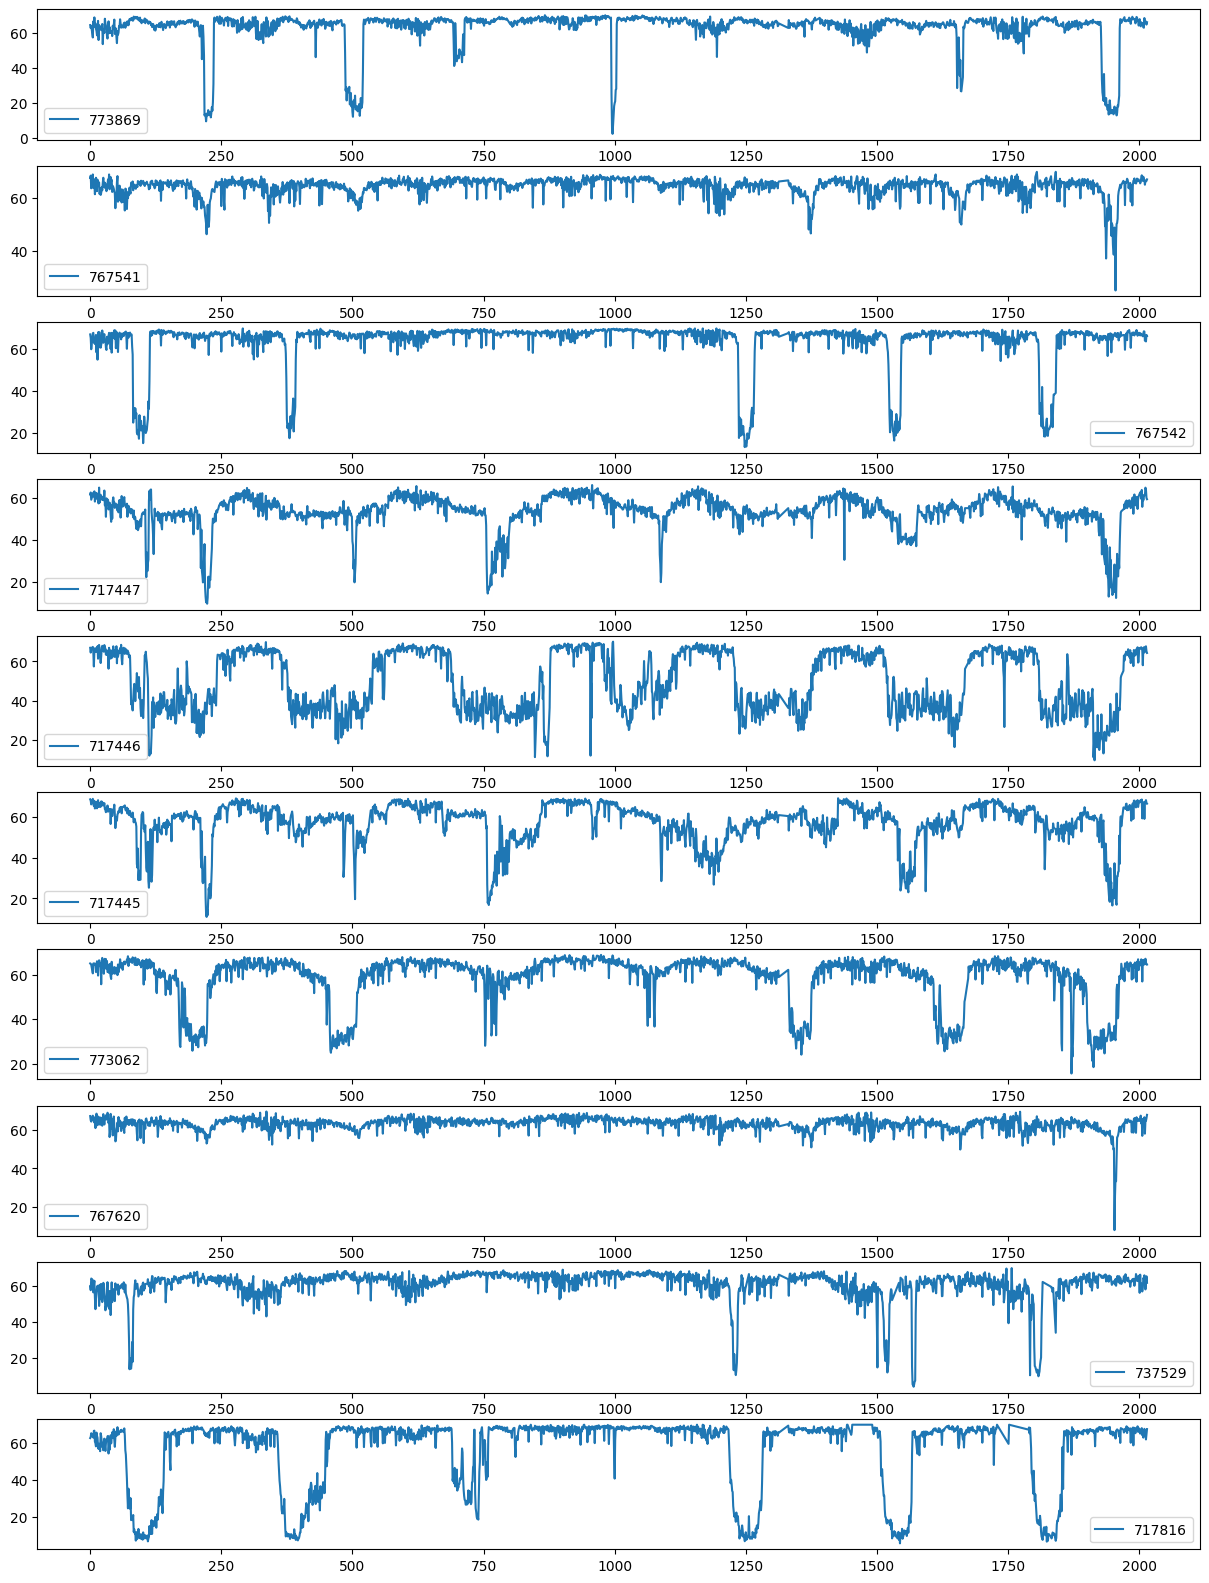

In [ ]:
plt.figure(figsize=(15,20))
for i in range(10):
    plt.subplot(10,1,i+1)
    plt.plot(data.iloc[:,i])
    plt.legend([sensors[i]])
plt.show()

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

In [ ]:
adj

matrix([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.71743792, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.71743792, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]])

In [ ]:
list_connected_sensors = []
adjascent = adj.T
for i in range(len(sensors)):
    conn_list = np.where(adjascent[i]!=0)[1].tolist()
    #print(conn_list)
    #print(data.columns[conn_list].tolist())
    list_connected_sensors.append(data.columns[conn_list].tolist())
print(list_connected_sensors[0])

['773869', '773906', '760987', '718204', '773927', '773953', '773954', '773880', '773916', '717576', '717573', '717572', '717570', '718090', '718496', '773904', '718499', '761003', '774204']


In [ ]:
import itertools

In [ ]:
G = nx.Graph()
for adj_sensors in list_connected_sensors:
    if len(adj_sensors)>=1:
        G.add_nodes_from(adj_sensors)
        for pair in itertools.combinations(adj_sensors, 2):
            G.add_edge(pair[0], pair[1])

n_edges_total = len(list(G.edges))
print("Total connected sensors: ",n_edges_total)
n_nodes = len(list(G.nodes))
n_edges_possible = (n_nodes*(n_nodes-1))/2
print("Percentage of connected network:", round((n_edges_total/n_edges_possible)*100,2),"%")

Total connected sensors:  3697
Percentage of connected network: 17.34 %


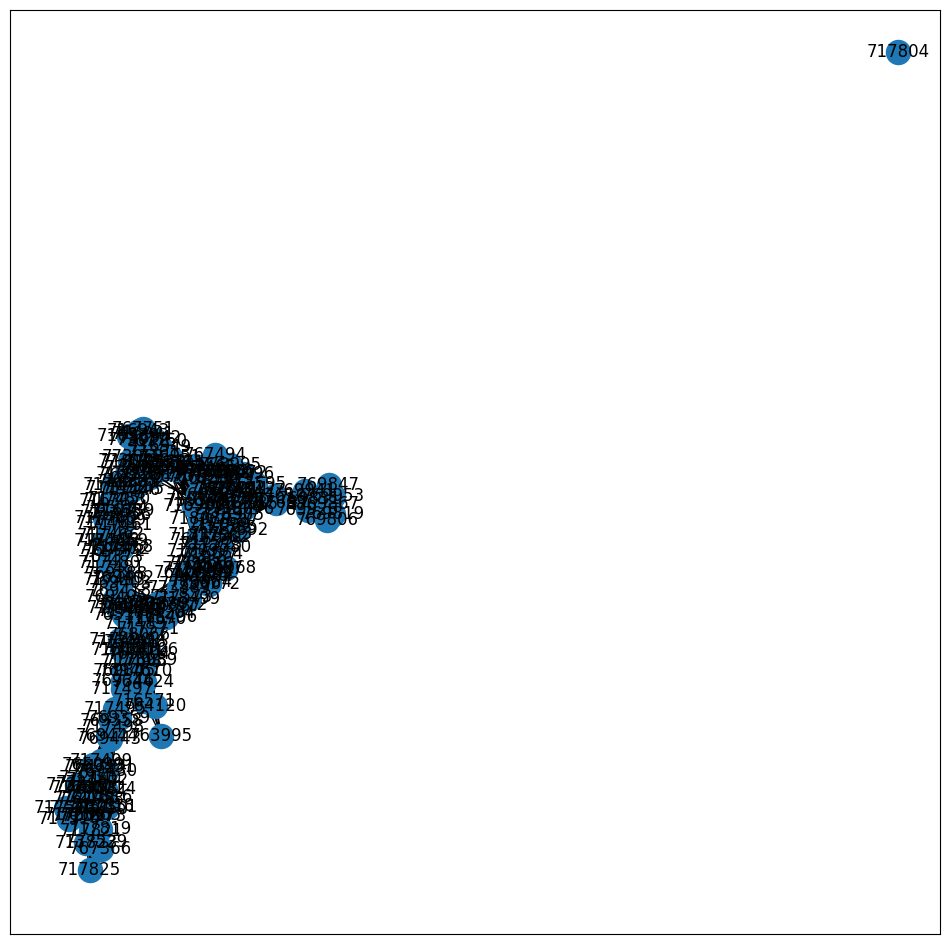

In [ ]:
fig = plt.figure(figsize=(12,12))
nx.draw_networkx(G, with_labels=True)

#### Preprocessing and train test split

In [ ]:
# Test/Train Split

In [ ]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:,:train_size])
    test_data = np.array(data.iloc[:,train_size:])
    return train_data, test_data

In [ ]:
train_rate = 0.8

In [ ]:
train_data, test_data = train_test_split(data.T, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


In [ ]:
# Scaling data

In [ ]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled, max_speed, min_speed

In [ ]:
def normalize_data(train_data, test_data):
    mean_speed = train_data.mean(axis=0)
    std_speed = train_data.std(axis=0)
    train_scaled = (train_data - mean_speed) / std_speed
    test_scaled = (test_data - mean_speed) / std_speed
    return train_scaled, test_scaled, mean_speed, std_speed

In [ ]:
train_scaled, test_scaled, max_speed, min_speed = scale_data(train_data, test_data)

#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

Define a function below to return the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [ ]:
seq_len = 10
pre_len = 12

learning_rate = 0.001
batch_size = 60
epochs = 100

In [ ]:
def preprocess_sequence_data(seq_len, pre_len, train_data, test_data):

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(train_data.shape[1] - int(seq_len + pre_len -1)):
        a = train_data[:, i: i + seq_len + pre_len]
        trainX.append(a[:, 0 : seq_len])
        trainY.append(a[:, -1])
    for i in range(test_data.shape[1] - int(seq_len +pre_len -1)):
        b = test_data[:, i: i + seq_len + pre_len]
        testX.append(b[:, 0 : seq_len])
        testY.append(b[:, -1])

    trainX1 = np.array(trainX)
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

In [ ]:
X_train, y_train, X_test, y_test = preprocess_sequence_data(
    seq_len, pre_len, train_scaled, test_scaled
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


### Build and Train the LSTM model and plot the loss results (3 points)

In [ ]:
features = 207
# define the LSTM model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(features, seq_len)),
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.4),
    TimeDistributed(Dense(1, activation='tanh')),
])

In [ ]:
# compile the model
#optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
model_lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)
# fit the model to the training data
history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=epochs, batch_size= batch_size,
                              validation_data=(X_test, y_test),
                              callbacks= [es_callback, modelckpt_callback])

Epoch 1/100
27/27 [==============================] - 14s 374ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 2/100
27/27 [==============================] - 8s 315ms/step - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 3/100
27/27 [==============================] - 8s 280ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 4/100
27/27 [==============================] - 9s 340ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 5/100
27/27 [==============================] - 7s 278ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 6/100
27/27 [==============================] - 9s 336ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 7/100
27/27 [==============================] - 9s 350ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 8/100
27/27 [==============================] - 9s 340ms/step -

In [ ]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 207, 64)           19200     
                                                                 
 dropout_6 (Dropout)         (None, 207, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 207, 64)           33024     
                                                                 
 dropout_7 (Dropout)         (None, 207, 64)           0         
                                                                 
 time_distributed_3 (TimeDi  (None, 207, 1)            65        
 stributed)                                                      
                                                                 
Total params: 52289 (204.25 KB)
Trainable params: 52289 (204.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________

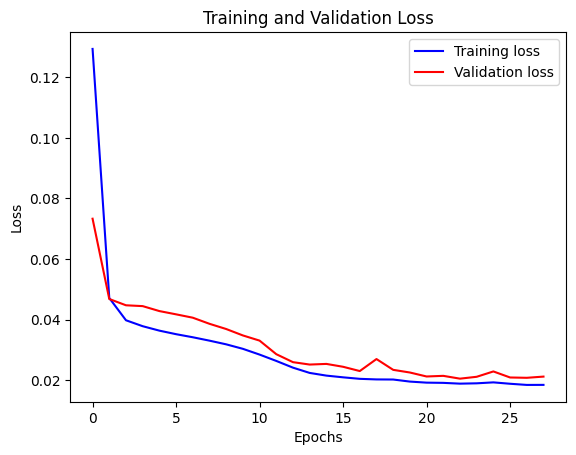

In [ ]:
# define a function to plot loss
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history_lstm, "Training and Validation Loss")

In [ ]:
print(
    "Train loss: ",
    history_lstm.history["loss"][-1],
    "\nTest loss:",
    history_lstm.history["val_loss"][-1],
)

Train loss:  0.018446484580636024 
Test loss: 0.021180137991905212


### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [ ]:
from stellargraph.layer import GCN_LSTM

In [ ]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=adjascent,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

<ipython-input-31-417c7fc62c53>:1: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


In [ ]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [ ]:
model = Model(inputs=x_input, outputs=x_output)

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=(X_test, y_test),
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207, 10)]         0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 207, 10, 1)        0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 207, 10)           0         
                                                                 
 fixed_adjacency_graph_conv  (None, 207, 16)           43216     
 olution (FixedAdjacencyGra                                      
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_conv  (None, 207, 10)           43216     
 olution_1 (FixedAdjacencyG                                  

In [ ]:
# YOUR CODE HERE to plot the loss

In [ ]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.007885976694524288 
Test loss: 0.01546737365424633


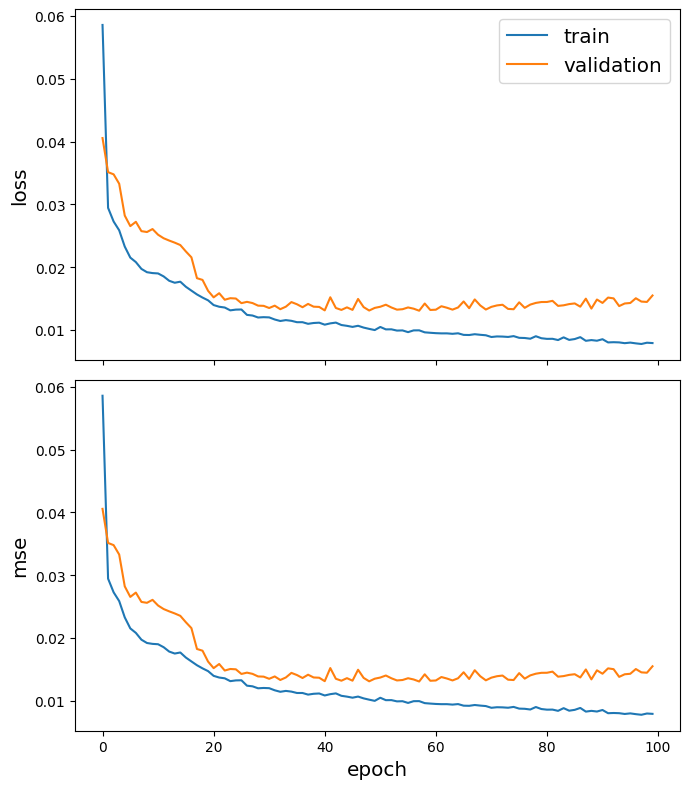

In [ ]:
sg.utils.plot_history(history)

In [ ]:
# Predictions
yt_hat = model.predict(X_train)
y_hat = model.predict(X_test)

12/12 [==============================] - 0s 24ms/step


#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [ ]:
## actual train and test values
y_train_rescaled = np.array(y_train * max_speed)
y_test_rescaled = np.array(y_test * max_speed)

In [ ]:
## Rescale model predicted values
y_train_hat_rescaled = np.array((yt_hat) * max_speed)
y_test_hat_rescaled = np.array((y_hat) * max_speed)

### Plot the predictions and Loss of each sensor ( 2 points)

* Select any one sensor's prediction and plot the graph.

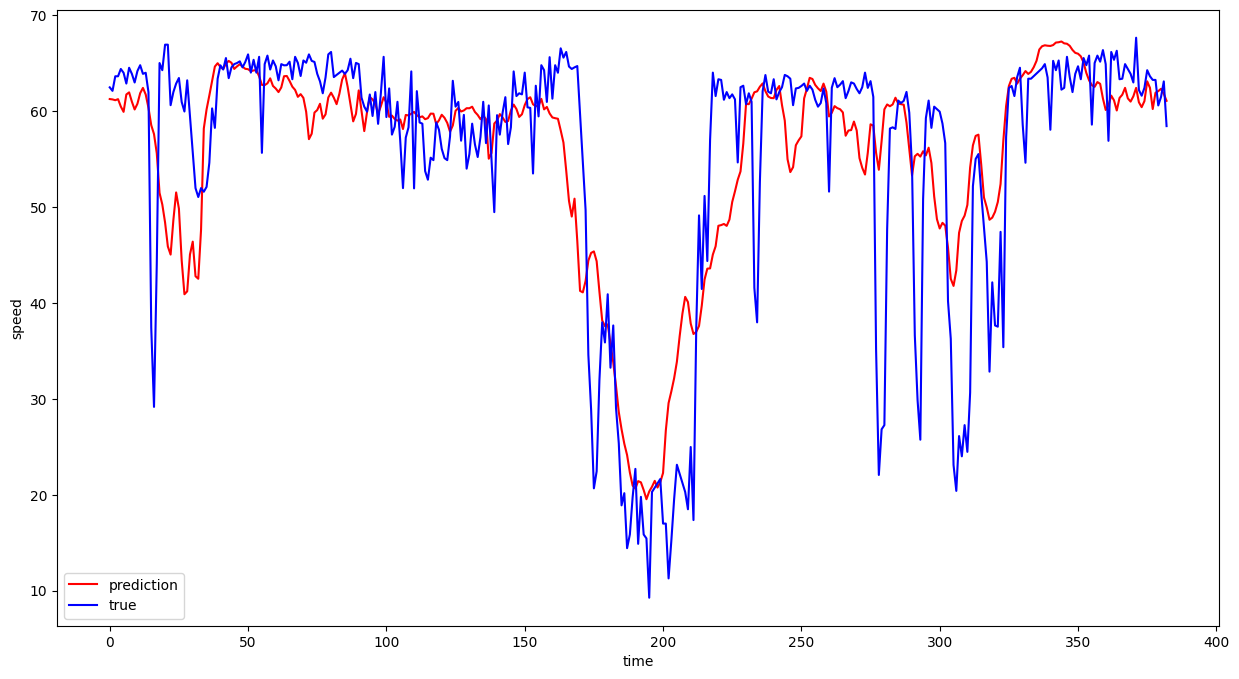

In [ ]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = y_test_hat_rescaled[:, 100]
a_true = y_test_rescaled[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

#### Plot error (MAE and MSE) for all the sensors

In [ ]:
seg_mae = []
seg_mse = []


for j in range(X_test.shape[-1]):

    seg_mae.append(
        np.mean(np.abs(y_test_rescaled.T[j] - y_test_hat_rescaled.T[j]))
    )  # Mean Absolute Error
    seg_mse.append(
        np.mean(np.square(y_test_rescaled.T[j] - y_test_hat_rescaled.T[j]))
    )  # Mean Squared Error


print("Total (ave) MAE for GNN_LSTM: " + str(np.mean(np.array(seg_mae))))
print("Total (ave) MSE for GNN_LSTM: " + str(np.mean(np.array(seg_mse))))

Total (ave) MAE for GNN_LSTM: 4.312603649237644
Total (ave) MSE for GNN_LSTM: 52.02891407059094


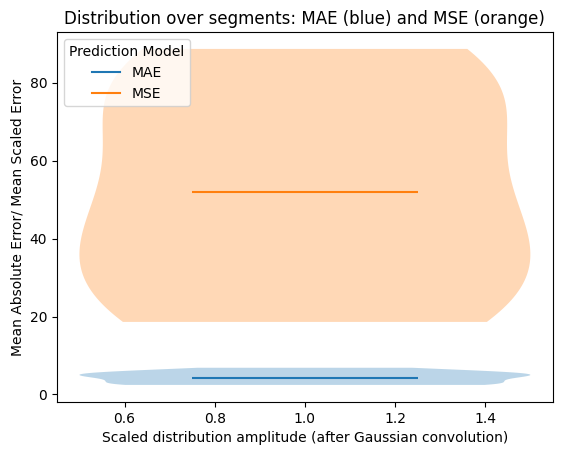

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# plot violin plot of MAE
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mae), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_mse), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="MAE")
line2 = mlines.Line2D([], [], color="C1", label="MSE")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error/ Mean Scaled Error")
ax.set_title("Distribution over segments: MAE (blue) and MSE (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Report Analysis


  * Discuss: Why is this called a spatio-temporal problem?
    - Traffic forecasting has always been considered an open scientific issue, owing to the constraints of urban road network topological structure and the law of dynamic change with time, namely, spatial dependence and temporal dependence. The task is challenging due to two main inter-linked factors: (1) the complex spatial dependency on road networks, and (2) non-linear temporal dynamics with changing road conditions.
    Sources: https://arxiv.org/abs/1811.05320, https://stellargraph.readthedocs.io/en/latest/demos/time-series/gcn-lstm-time-series.html#Forecasting-using-spatio-temporal-data-with-combined-Graph-Convolution-+-LSTM-model

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?
   - LSTM models take the temporal feature into account but ignore the spatial dependence, so that the change of traffic data is not constrained by the urban road network and thus they cannot accurately predict the traffic state on the road. Making full use of the spatial and temporal dependence is the key to solving traffic forecasting problems that GCN-LSTM accounts for.